# Gaussian Process

Gaussian Processes (GP) are a generic supervised learning method designed to solve regression and probabilistic classification problems. 

https://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process

In [2]:
%load_ext autoreload
%autoreload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from scipy import stats

from MLP.mlp_regression import mlp_regression, model_validation, mlp_prediction, mlp_prediction_error, 
                            mlp_train_graph, errorDist, mlp_train_multi_graph, mlp_train_multi_graph_comb, mlp_train_multi_3dgraph_comb
from MLP.utils import data_loader_pathloss, describeData, data_loader_pathloss_with_freq
from GMM.utils import gp_train_multi_3dgraph, gp_ann_train_multi_3dgraph, gpCompareDiffDim, mergeSet

pd.set_option('display.max_rows', 999)
pd.set_option('precision', 5)

In [2]:
%autoreload
X_train_bh_34, y_train_bh_34, X_val_bh_34, y_val_bh_34, X_test_bh_34, y_test_bh_34 = data_loader_pathloss('data/PLdata_bh_34.mat')
X_train_bh_53, y_train_bh_53, X_val_bh_53, y_val_bh_53, X_test_bh_53, y_test_bh_53 = data_loader_pathloss('data/PLdata_bh_53.mat')
X_train_bh_64, y_train_bh_64, X_val_bh_64, y_val_bh_64, X_test_bh_64, y_test_bh_64 = data_loader_pathloss('data/PLdata_bh_64.mat')

X_train_bh = mergeSet(X_train_bh_34, X_train_bh_53, X_train_bh_64)
y_train_bh = mergeSet(y_train_bh_34, y_train_bh_53, y_train_bh_64)
X_val_bh = mergeSet(X_val_bh_34, X_val_bh_53, X_val_bh_64)
y_val_bh = mergeSet(y_val_bh_34, y_val_bh_53, y_val_bh_64)
X_test_bh = mergeSet(X_test_bh_34, X_test_bh_53, X_test_bh_64)
y_test_bh = mergeSet(y_test_bh_34, y_test_bh_53, y_test_bh_64)

X_train_ma_34, y_train_ma_34, X_val_ma_34, y_val_ma_34, X_test_ma_34, y_test_ma_34 = data_loader_pathloss('data/PLdata_ma_34.mat')
X_train_ma_53, y_train_ma_53, X_val_ma_53, y_val_ma_53, X_test_ma_53, y_test_ma_53 = data_loader_pathloss('data/PLdata_ma_53.mat')
X_train_ma_64, y_train_ma_64, X_val_ma_64, y_val_ma_64, X_test_ma_64, y_test_ma_64 = data_loader_pathloss('data/PLdata_ma_64.mat')

X_train_ma = mergeSet(X_train_ma_34, X_train_ma_53, X_train_ma_64)
y_train_ma = mergeSet(y_train_ma_34, y_train_ma_53, y_train_ma_64)
X_val_ma = mergeSet(X_val_ma_34, X_val_bh_53, X_val_ma_64)
y_val_ma = mergeSet(y_val_ma_34, y_val_bh_53, y_val_ma_64)
X_test_ma = mergeSet(X_test_ma_34, X_test_ma_53, X_test_ma_64)
y_test_ma = mergeSet(y_test_ma_34, y_test_ma_53, y_test_ma_64)

<Bundang>


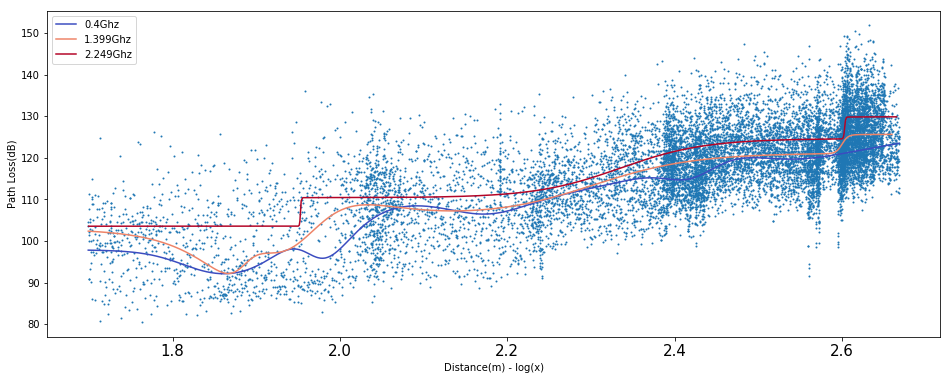

RMSE(dB),train error,test error
3.4Ghz,6.90821,6.80130
5.3Ghz,6.86653,6.96527
6.4Ghz,7.43953,7.06425


In [48]:
%autoreload
dataX = list()
dataY = list()
dataPredX = list()
model_34 = mlp_regression(X_train_bh_34, y_train_bh_34, (60), 'logistic', 'lbfgs')
dataX.append(X_train_bh_34)
dataY.append(y_train_bh_34)
dataPredX.append(model_34.predict(X_train_bh_34))
model_53 = mlp_regression(X_train_bh_53, y_train_bh_53, (60), 'logistic', 'lbfgs')
dataX.append(X_train_bh_53)
dataY.append(y_train_bh_53)
dataPredX.append(model_53.predict(X_train_bh_53))
model_64 = mlp_regression(X_train_bh_64, y_train_bh_64, (60), 'logistic', 'lbfgs')
dataX.append(X_train_bh_64)
dataY.append(y_train_bh_64)
dataPredX.append(model_64.predict(X_train_bh_64))

print("<Bundang>")
mlp_train_multi_graph(dataX, dataY, dataPredX, X_train_bh, y_train_bh, 'distance')

stat = np.array([mlp_prediction_error(model_34,X_train_bh_34, y_train_bh_34), mlp_prediction_error(model_34,X_test_bh_34, y_test_bh_34),
                 mlp_prediction_error(model_53,X_train_bh_53, y_train_bh_53),mlp_prediction_error(model_53,X_test_bh_53, y_test_bh_53),
                 mlp_prediction_error(model_64,X_train_bh_64, y_train_bh_64),mlp_prediction_error(model_64,X_test_bh_64, y_test_bh_64)])

(pd.DataFrame(stat.reshape((3,2)),index=pd.Index(['3.4Ghz','5.3Ghz','6.4Ghz']), columns=pd.Index(['train error','test error'],name='RMSE(dB)')))

In [49]:
X = X_train_bh
y = y_train_bh

# Instantiate a Gaussian Process model
# kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
# kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
#    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
gp_bh = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0)
# Fit to data using Maximum Likelihood Estimation of the parameters
gp_bh.fit(X, y)

GaussianProcessRegressor(alpha=0.0, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [3]:
X = X_train_ma
y = y_train_ma

# Instantiate a Gaussian Process model
# kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
# kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
#    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
gp_ma = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0)
# Fit to data using Maximum Likelihood Estimation of the parameters
gp_ma.fit(X, y)

GaussianProcessRegressor(alpha=0.0, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [4]:
filename = 'model/gp_ma_2d_model.sav'
pickle.dump(gp_ma, open(filename, 'wb'))

In [50]:
filename = 'model/gp_bh_2d_model.sav'
pickle.dump(gp_bh, open(filename, 'wb'))

In [5]:
# load the model from disk
gp_bh_2d_model = pickle.load(open('model/gp_bh_2d_model.sav', 'rb'))
gp_ma_2d_model = pickle.load(open('model/gp_ma_2d_model.sav', 'rb'))

Pathloss Noise modeling(3D) - 3.4Ghz Bundang


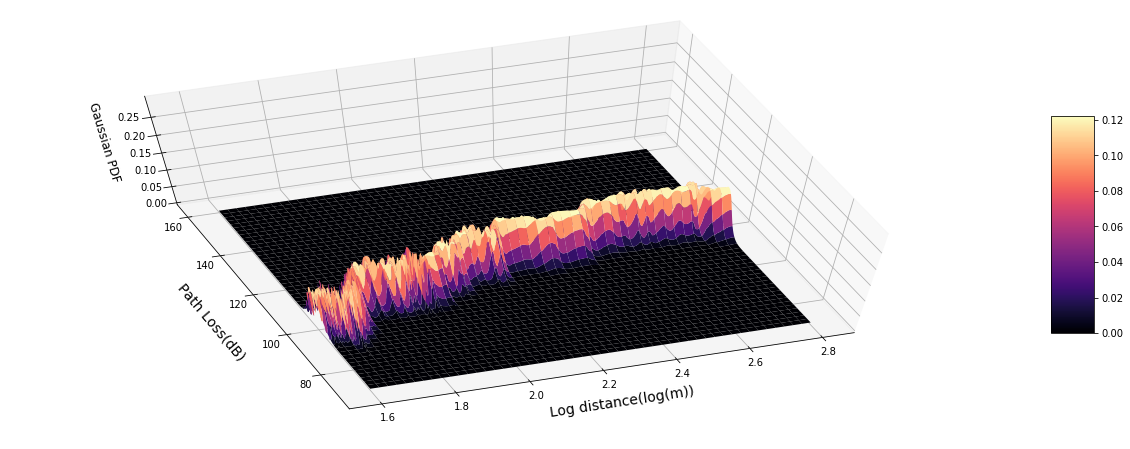

In [9]:
%autoreload
X = X_train_bh
y = y_train_bh

y_pred, sigma = gp_bh_2d_model.predict(X, return_std=True)

x = np.linspace(1.6, 2.8, 3000)
y = np.linspace(70, 160, 3000)
z = np.zeros((len(x), len(y)))
for t in range(len(x)):
    gd = scipy.stats.norm(y_pred[t], sigma[t])
    z[t] = np.array(gd.pdf(y))
# print(z)

print('Pathloss Noise modeling(3D) - 3.4Ghz Bundang')

fig = plt.figure()
fig.set_figwidth(22)
fig.set_figheight(8)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x.reshape(-1,1), y, z, cmap=cm.magma, linewidth=0, antialiased=True)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title
# ax.view_init(75, 255)
ax.view_init(elev=65, azim=250)
ax.set_zlim(0.0,0.3)
ax.set_xlabel("Log distance(log(m))",labelpad=18,fontsize=14)
ax.set_ylabel("Path Loss(dB)",labelpad=18,fontsize=14)
ax.set_zlabel("Gaussian PDF",labelpad=10,fontsize=12)

#plt.axis('tight')
plt.show()

Pathloss Noise modeling(3D) - 3.4Ghz Bundang


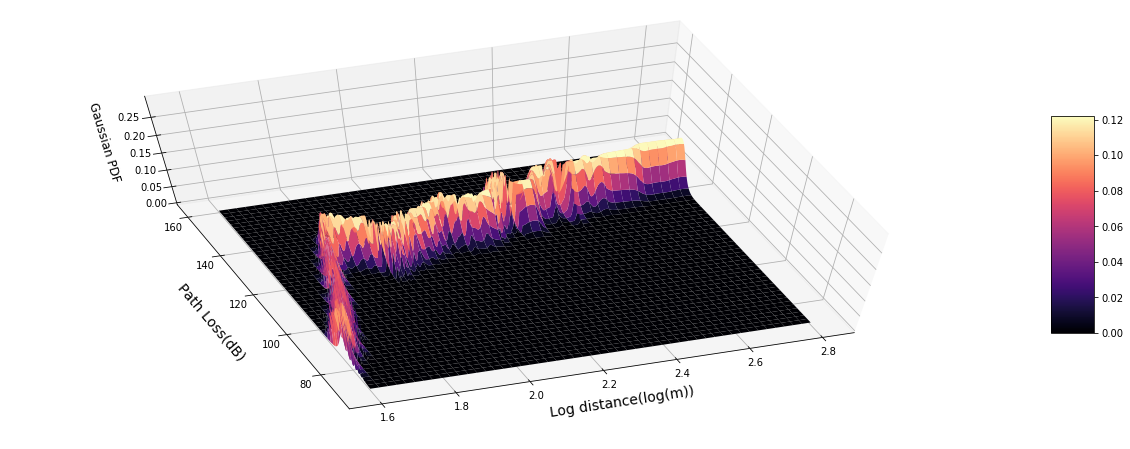

In [6]:
%autoreload
X = X_train_ma
y = y_train_ma

y_pred, sigma = gp_ma_2d_model.predict(X, return_std=True)

x = np.linspace(1.6, 2.8, 3000)
y = np.linspace(70, 160, 3000)
z = np.zeros((len(x), len(y)))
for t in range(len(x)):
    gd = scipy.stats.norm(y_pred[t], sigma[t])
    z[t] = np.array(gd.pdf(y))
# print(z)

print('Pathloss Noise modeling(3D) - 3.4Ghz Bundang')

fig = plt.figure()
fig.set_figwidth(22)
fig.set_figheight(8)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x.reshape(-1,1), y, z, cmap=cm.magma, linewidth=0, antialiased=True)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title
# ax.view_init(75, 255)
ax.view_init(elev=65, azim=250)
ax.set_zlim(0.0,0.3)
ax.set_xlabel("Log distance(log(m))",labelpad=18,fontsize=14)
ax.set_ylabel("Path Loss(dB)",labelpad=18,fontsize=14)
ax.set_zlabel("Gaussian PDF",labelpad=10,fontsize=12)

#plt.axis('tight')
plt.show()

In [5]:
%autoreload
X_train_bh_34, y_train_bh_34, X_val_bh_34, y_val_bh_34, X_test_bh_34, y_test_bh_34 = data_loader_pathloss_with_freq('data/PLdata_bh_34.mat',np.log10(3400))
X_train_bh_53, y_train_bh_53, X_val_bh_53, y_val_bh_53, X_test_bh_53, y_test_bh_53 = data_loader_pathloss_with_freq('data/PLdata_bh_53.mat',np.log10(5300))
X_train_bh_64, y_train_bh_64, X_val_bh_64, y_val_bh_64, X_test_bh_64, y_test_bh_64 = data_loader_pathloss_with_freq('data/PLdata_bh_64.mat',np.log10(6400))

X_train_bh = mergeSet(X_train_bh_34, X_train_bh_53, X_train_bh_64)
y_train_bh = mergeSet(y_train_bh_34, y_train_bh_53, y_train_bh_64)
X_val_bh = mergeSet(X_val_bh_34, X_val_bh_53, X_val_bh_64)
y_val_bh = mergeSet(y_val_bh_34, y_val_bh_53, y_val_bh_64)
X_test_bh = mergeSet(X_test_bh_34, X_test_bh_53, X_test_bh_64)
y_test_bh = mergeSet(y_test_bh_34, y_test_bh_53, y_test_bh_64)

df_train_bh = pd.DataFrame({'X_train1':X_train_bh[:,0],'X_train2':X_train_bh[:,1], 'y_train':y_train_bh}).sort_values(by=['X_train1'])
X_train_bh = np.concatenate((np.array(df_train_bh['X_train1']).reshape(-1,1),np.array(df_train_bh['X_train2']).reshape(-1,1)),axis=1)
y_train_bh = np.array(df_train_bh['y_train'])
df_val_bh = pd.DataFrame({'X_val1':X_val_bh[:,0],'X_val2':X_val_bh[:,1], 'y_val':y_val_bh}).sort_values(by=['X_val1'])
X_val_bh = np.concatenate((np.array(df_val_bh['X_val1']).reshape(-1,1),np.array(df_val_bh['X_val2']).reshape(-1,1)),axis=1)
y_val_bh = np.array(df_val_bh['y_val'])
df_test_bh = pd.DataFrame({'X_test1':X_test_bh[:,0],'X_test2':X_test_bh[:,1], 'y_test':y_test_bh}).sort_values(by=['X_test1'])
X_test_bh = np.concatenate((np.array(df_test_bh['X_test1']).reshape(-1,1),np.array(df_test_bh['X_test2']).reshape(-1,1)),axis=1)
y_test_bh = np.array(df_test_bh['y_test'])

X_train_ma_34, y_train_ma_34, X_val_ma_34, y_val_ma_34, X_test_ma_34, y_test_ma_34 = data_loader_pathloss_with_freq('data/PLdata_ma_34.mat',np.log10(3400))
X_train_ma_53, y_train_ma_53, X_val_ma_53, y_val_ma_53, X_test_ma_53, y_test_ma_53 = data_loader_pathloss_with_freq('data/PLdata_ma_53.mat',np.log10(5300))
X_train_ma_64, y_train_ma_64, X_val_ma_64, y_val_ma_64, X_test_ma_64, y_test_ma_64 = data_loader_pathloss_with_freq('data/PLdata_ma_64.mat',np.log10(6400))

X_train_ma = np.concatenate((X_train_ma_34, X_train_ma_53), axis=0)
y_train_ma = np.concatenate((y_train_ma_34, y_train_ma_53),axis=0)
X_train_ma = np.concatenate((X_train_ma, X_train_ma_64), axis=0)
y_train_ma = np.concatenate((y_train_ma, y_train_ma_64),axis=0)
df_train_ma = pd.DataFrame({'X_train1':X_train_ma[:,0],'X_train2':X_train_ma[:,1], 'y_train':y_train_ma}).sort_values(by=['X_train1'])
X_train_ma = np.concatenate((np.array(df_train_ma['X_train1']).reshape(-1,1),np.array(df_train_ma['X_train2']).reshape(-1,1)),axis=1)
y_train_ma = np.array(df_train_ma['y_train'])

X_val_ma = np.concatenate((X_val_ma_34, X_val_ma_53), axis=0)
y_val_ma = np.concatenate((y_val_ma_34, y_val_ma_53),axis=0)
X_val_ma = np.concatenate((X_val_ma, X_val_ma_64), axis=0)
y_val_ma = np.concatenate((y_val_ma, y_val_ma_64),axis=0)
df_val_ma = pd.DataFrame({'X_val1':X_val_ma[:,0],'X_val2':X_val_ma[:,1], 'y_val':y_val_ma}).sort_values(by=['X_val1'])
X_val_ma = np.concatenate((np.array(df_val_ma['X_val1']).reshape(-1,1),np.array(df_val_ma['X_val2']).reshape(-1,1)),axis=1)
y_val_ma = np.array(df_val_ma['y_val'])

X_test_ma = np.concatenate((X_test_ma_34, X_test_ma_53), axis=0)
y_test_ma = np.concatenate((y_test_ma_34, y_test_ma_53),axis=0)
X_test_ma = np.concatenate((X_test_ma, X_test_ma_64), axis=0)
y_test_ma = np.concatenate((y_test_ma, y_test_ma_64),axis=0)
df_test_ma = pd.DataFrame({'X_test1':X_test_ma[:,0],'X_test2':X_test_ma[:,1], 'y_test':y_test_ma}).sort_values(by=['X_test1'])
X_test_ma = np.concatenate((np.array(df_test_ma['X_test1']).reshape(-1,1),np.array(df_test_ma['X_test2']).reshape(-1,1)),axis=1)
y_test_ma = np.array(df_test_ma['y_test'])


In [6]:
%autoreload
dataX_bh = list()
dataY_bh = list()
dataX_bh.append(X_train_bh_34)
dataY_bh.append(y_train_bh_34)
dataX_bh.append(X_train_bh_53)
dataY_bh.append(y_train_bh_53)
dataX_bh.append(X_train_bh_64)
dataY_bh.append(y_train_bh_64)

dataX_ma = list()
dataY_ma = list()
dataX_ma.append(X_train_ma_34)
dataY_ma.append(y_train_ma_34)
dataX_ma.append(X_train_ma_53)
dataY_ma.append(y_train_ma_53)
dataX_ma.append(X_train_ma_64)
dataY_ma.append(y_train_ma_64)

<Bundang>


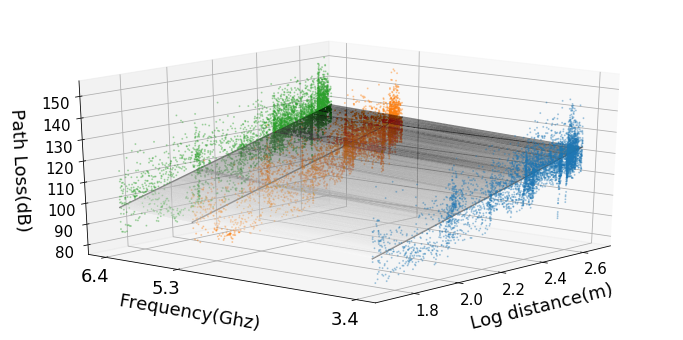

26.35985490936723
230
7
1


RMSE(dB),train error,val error,test error
3.4Ghz,7.00694,7.13711,7.20461
5.3Ghz,7.16885,7.19501,7.35012
6.4Ghz,7.60213,7.87089,7.66916
Overall,7.26083,7.40375,7.40853


In [9]:
%autoreload
ann_model = None
ann_model = mlp_regression(X_train_bh, y_train_bh, (60, 60, 60, 60, 60,), 'relu', 'lbfgs')

print("<Bundang>")
mlp_train_multi_3dgraph_comb(ann_model, dataX_bh, dataY_bh, X_train_bh)

print(ann_model.loss_)
print(ann_model.n_iter_ )
print(ann_model.n_layers_)
print(ann_model.n_outputs_)
stat = np.array([mlp_prediction_error(ann_model,X_train_bh_34, y_train_bh_34),mlp_prediction_error(ann_model,X_val_bh_34, y_val_bh_34),mlp_prediction_error(ann_model,X_test_bh_34, y_test_bh_34),
                 mlp_prediction_error(ann_model,X_train_bh_53, y_train_bh_53),mlp_prediction_error(ann_model,X_val_bh_53, y_val_bh_53),mlp_prediction_error(ann_model,X_test_bh_53, y_test_bh_53),
                 mlp_prediction_error(ann_model,X_train_bh_64, y_train_bh_64),mlp_prediction_error(ann_model,X_val_bh_64, y_val_bh_64),mlp_prediction_error(ann_model,X_test_bh_64, y_test_bh_64),
                 mlp_prediction_error(ann_model,X_train_bh, y_train_bh), mlp_prediction_error(ann_model,X_val_bh, y_val_bh), mlp_prediction_error(ann_model,X_test_bh, y_test_bh)])

(pd.DataFrame(stat.reshape((4,3)),index=pd.Index(['3.4Ghz','5.3Ghz','6.4Ghz', 'Overall']), columns=pd.Index(['train error','val error','test error'],name='RMSE(dB)')))

In [11]:
# Instantiate a Gaussian Process model
# kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
# kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
#    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
gp_bh = GaussianProcessRegressor(kernel=kernel, alpha=0.0)

In [72]:
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
gp_ma = GaussianProcessRegressor(kernel=kernel, alpha=0.0)

In [12]:
X = X_train_bh
y = y_train_bh

# Fit to data using Maximum Likelihood Estimation of the parameters
gp_bh.fit(X, y)

GaussianProcessRegressor(alpha=0.0, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [73]:
X = X_train_ma
y = y_train_ma

# Fit to data using Maximum Likelihood Estimation of the parameters
gp_ma.fit(X, y)

GaussianProcessRegressor(alpha=0.0, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [76]:
import pickle
filename = 'model/gp_ma_model.sav'
pickle.dump(gp_ma, open(filename, 'wb'))

In [13]:
import pickle
filename = 'model/gp_bh_model.sav'
pickle.dump(gp_bh, open(filename, 'wb'))

In [74]:
import pickle
filename = 'model/gp_ma_model.sav'
pickle.dump(gp_ma, open(filename, 'wb'))

<Bundang>
(10, 13875)


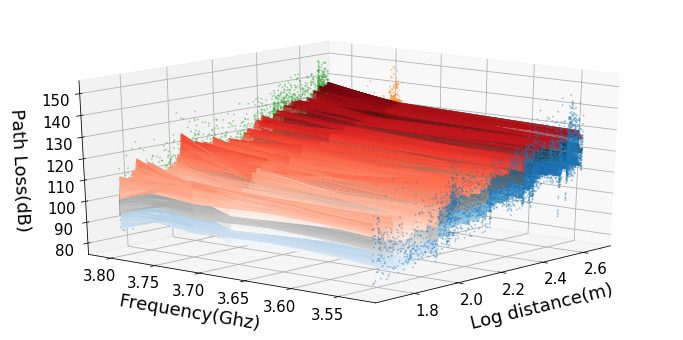

In [47]:
%autoreload
gp_model = gp_bh

print("<Bundang>")
gp_train_multi_3dgraph_comb(gp_model, dataX_bh, dataY_bh, X_train_bh)

<Bundang>


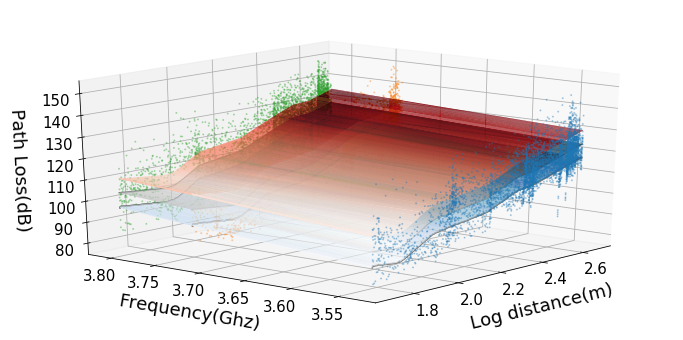

In [53]:
%autoreload
gp_model = gp

print("<Bundang>")
gp_ann_train_multi_3dgraph(gp_model, ann_model, dataX_bh, dataY_bh, X_train_bh)

# Comparison between 2D and 3D Gaussian Process models

### 1.Features
- 2D: pathloss / distance
- 3D: pathloss / (distance, frequency)

### 2.Models
- Bundang 2D model(gp_bh_2d_model)
- Bundang 3D model(gp_bh_3d_model)
- Mokdong 2D model(gp_ma_2d_model)
- Mokdong 3D model(gp_ma_3d_model)

### 3.Target Variable
- Mean
- Sigma(Standard Deviation)

In [4]:
# load the model from disk
gp_bh_2d_model = pickle.load(open('model/gp_bh_2d_model.sav', 'rb'))
gp_bh_3d_model = pickle.load(open('model/gp_bh_3d_model.sav', 'rb'))

In [7]:
y_2d_pred, d2_sigma = gp_bh_2d_model.predict(X_train_bh_34[:,0].reshape(-1,1), return_std=True)
y_3d_pred, d3_sigma = gp_bh_3d_model.predict(X_train_bh_34, return_std=True)

print(y_2d_pred.shape)
print(y_3d_pred.shape)

(4591,)
(4591,)


Bundang - Mean comparison for 3.4Ghz data


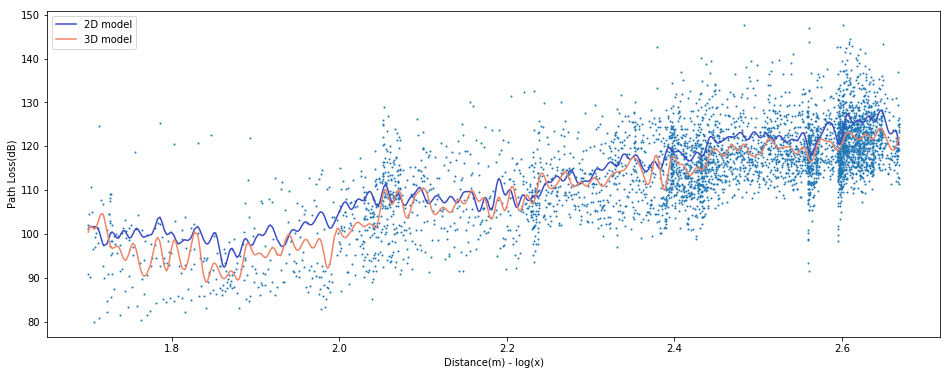

In [10]:
%autoreload
print("Bundang - Mean comparison for 3.4Ghz data")
gpCompareDiffDim(gp_bh_2d_model, gp_bh_3d_model, X_train_bh_34, y_train_bh_34, type='mean')

Bundang - Mean comparison for 5.3Ghz data


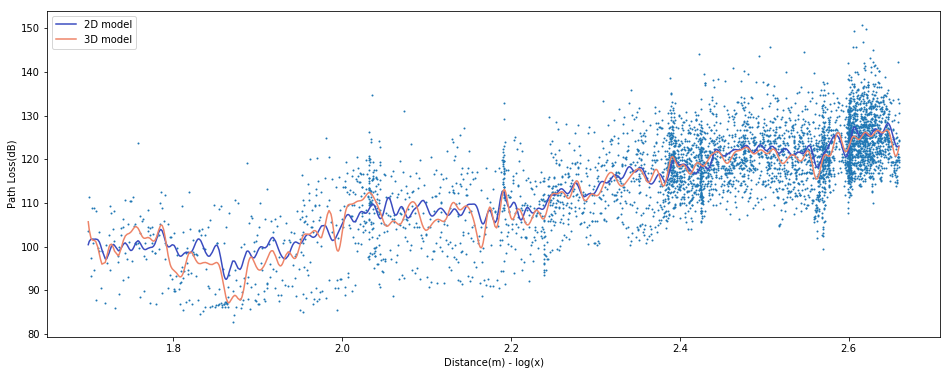

In [11]:
%autoreload
print("Bundang - Mean comparison for 5.3Ghz data")
gpCompareDiffDim(gp_bh_2d_model, gp_bh_3d_model, X_train_bh_53, y_train_bh_53, type='mean')

Bundang - Mean comparison for 6.4Ghz data


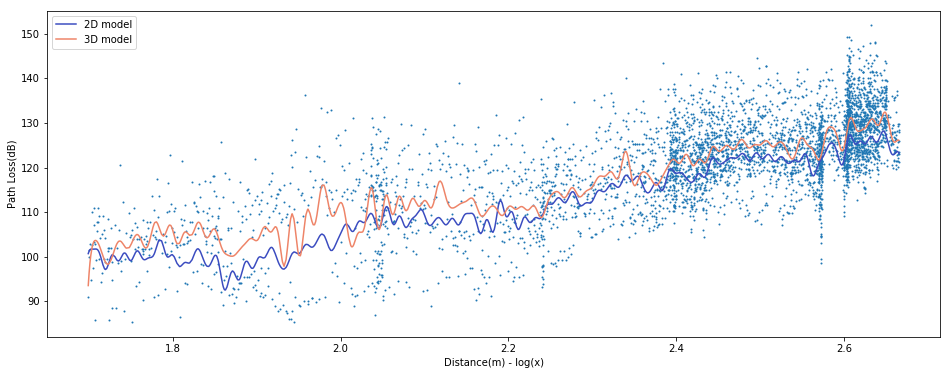

In [12]:
%autoreload
print("Bundang - Mean comparison for 6.4Ghz data")
gpCompareDiffDim(gp_bh_2d_model, gp_bh_3d_model, X_train_bh_64, y_train_bh_64, type='mean')

Bundang - Sigma(Standard Deviation) comparison for 3.4Ghz data


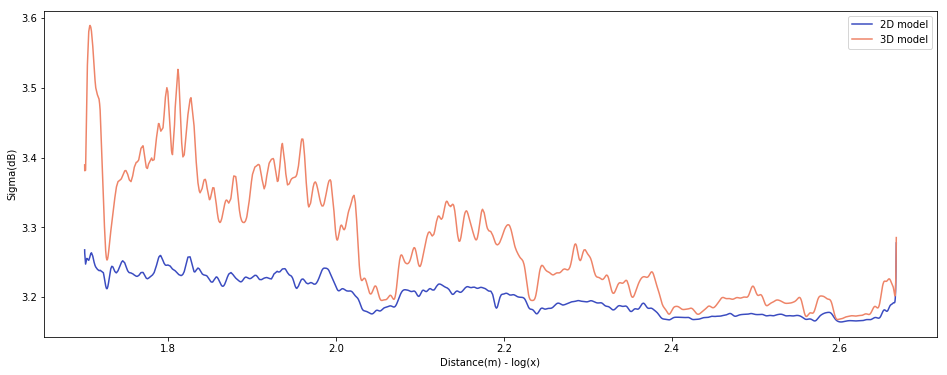

In [13]:
%autoreload
print("Bundang - Sigma(Standard Deviation) comparison for 3.4Ghz data")
gpCompareDiffDim(gp_bh_2d_model, gp_bh_3d_model, X_train_bh_34, y_train_bh_34, type='sigma')

Bundang - Sigma(Standard Deviation) comparison for 5.3Ghz data


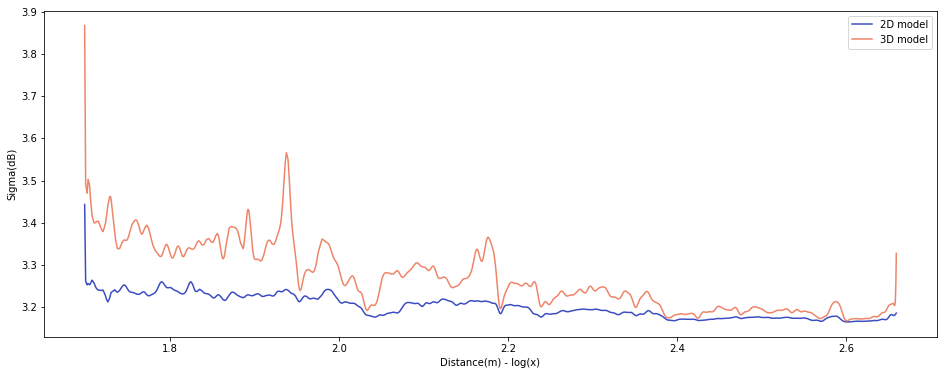

In [14]:
%autoreload
print("Bundang - Sigma(Standard Deviation) comparison for 5.3Ghz data")
gpCompareDiffDim(gp_bh_2d_model, gp_bh_3d_model, X_train_bh_53, y_train_bh_53, type='sigma')

Bundang - Sigma(Standard Deviation) comparison for 6.4Ghz data


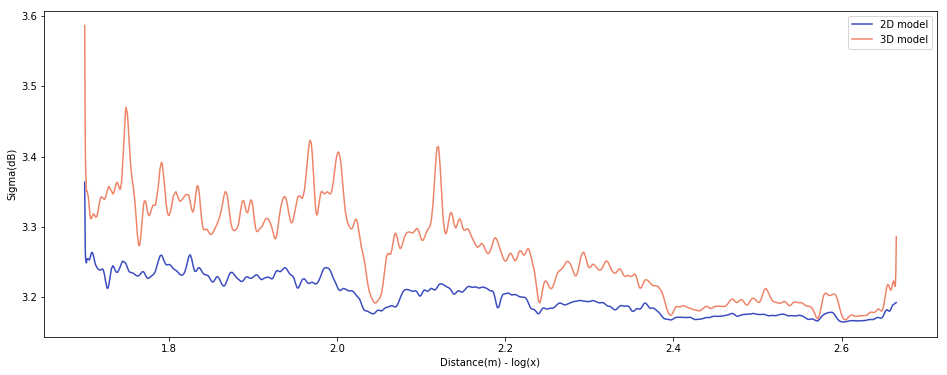

In [15]:
%autoreload
print("Bundang - Sigma(Standard Deviation) comparison for 6.4Ghz data")
gpCompareDiffDim(gp_bh_2d_model, gp_bh_3d_model, X_train_bh_64, y_train_bh_64, type='sigma')

In [16]:
# load the model from disk
gp_ma_2d_model = pickle.load(open('model/gp_ma_2d_model.sav', 'rb'))
gp_ma_3d_model = pickle.load(open('model/gp_ma_3d_model.sav', 'rb'))

Mokdong - Mean comparison for 3.4Ghz data


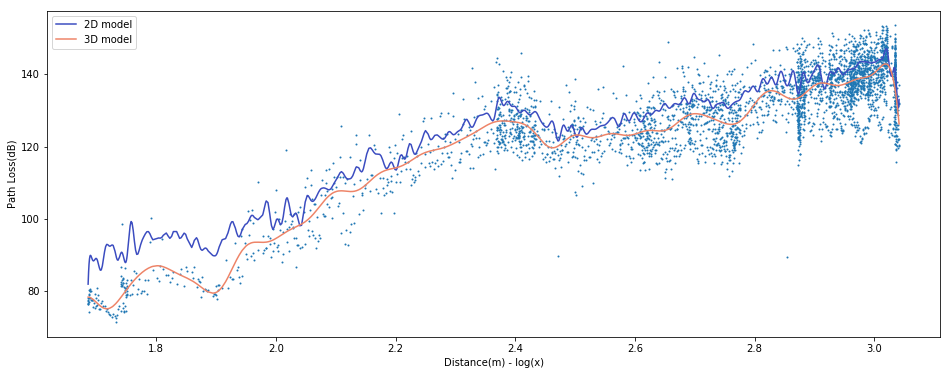

In [17]:
%autoreload
print("Mokdong - Mean comparison for 3.4Ghz data")
gpCompareDiffDim(gp_ma_2d_model, gp_ma_3d_model, X_train_ma_34, y_train_ma_34, type='mean')

Mokdong - Mean comparison for 5.3Ghz data


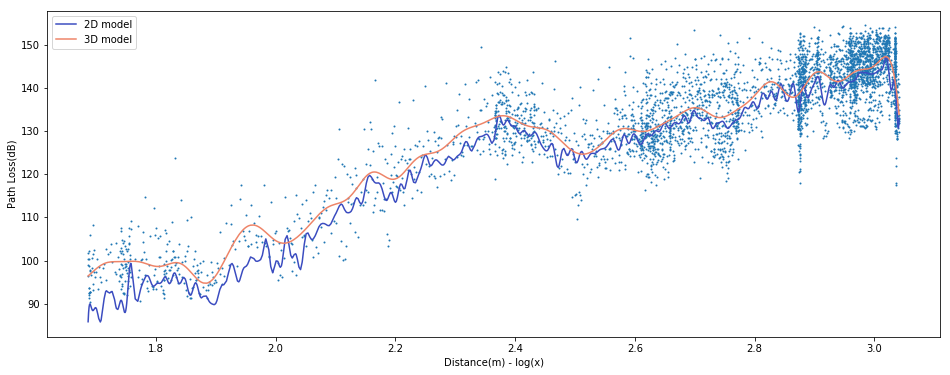

In [18]:
%autoreload
print("Mokdong - Mean comparison for 5.3Ghz data")
gpCompareDiffDim(gp_ma_2d_model, gp_ma_3d_model, X_train_ma_53, y_train_ma_53, type='mean')

Mokdong - Mean comparison for 6.4Ghz data


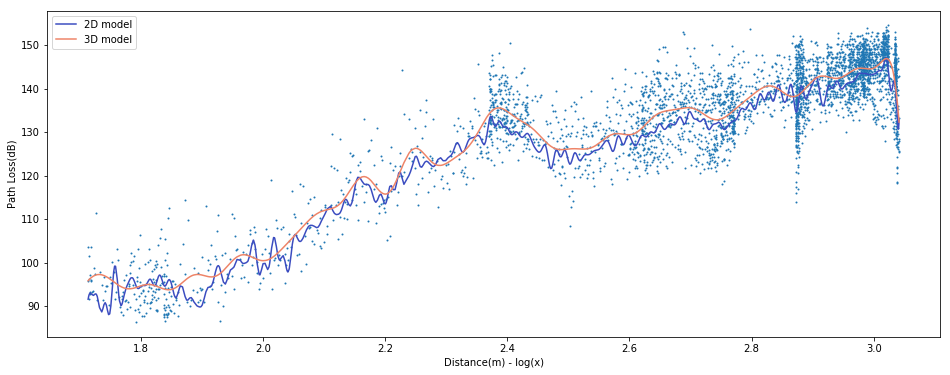

In [19]:
%autoreload
print("Mokdong - Mean comparison for 6.4Ghz data")
gpCompareDiffDim(gp_ma_2d_model, gp_ma_3d_model, X_train_ma_64, y_train_ma_64, type='mean')

Mokdong - Sigma(Standard Deviation) comparison for 3.4Ghz data


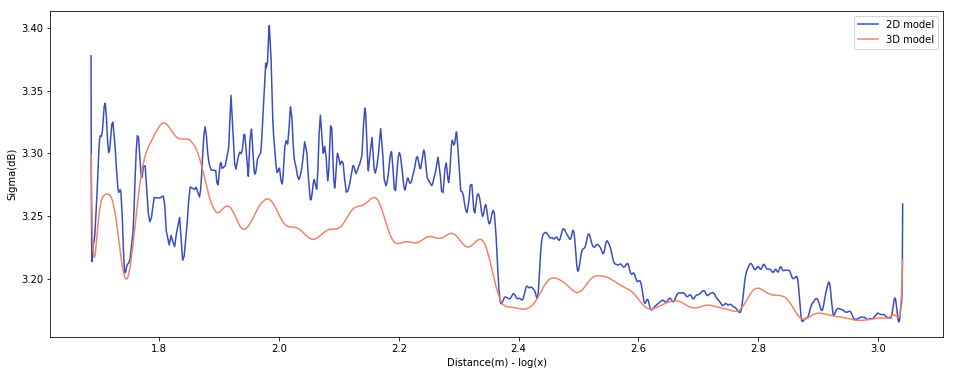

In [20]:
%autoreload
print("Mokdong - Sigma(Standard Deviation) comparison for 3.4Ghz data")
gpCompareDiffDim(gp_ma_2d_model, gp_ma_3d_model, X_train_ma_34, y_train_ma_34, type='sigma')

Mokdong - Sigma(Standard Deviation) comparison for 5.3Ghz data


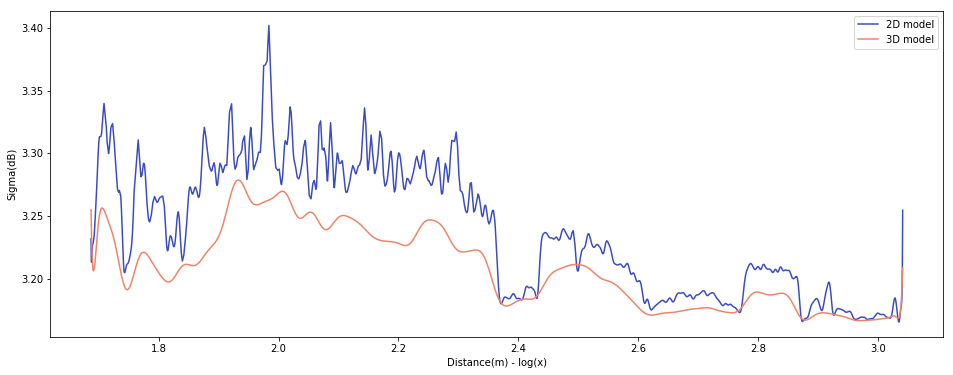

In [21]:
%autoreload
print("Mokdong - Sigma(Standard Deviation) comparison for 5.3Ghz data")
gpCompareDiffDim(gp_ma_2d_model, gp_ma_3d_model, X_train_ma_53, y_train_ma_53, type='sigma')

Mokdong - Sigma(Standard Deviation) comparison for 6.4Ghz data


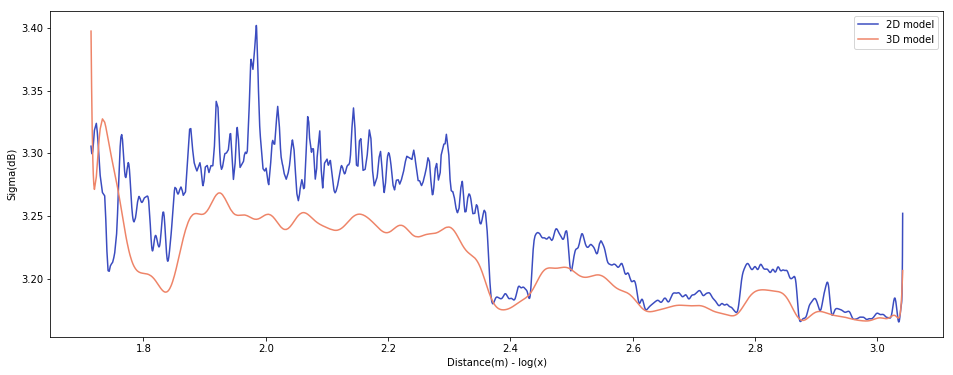

In [22]:
%autoreload
print("Mokdong - Sigma(Standard Deviation) comparison for 6.4Ghz data")
gpCompareDiffDim(gp_ma_2d_model, gp_ma_3d_model, X_train_ma_64, y_train_ma_64, type='sigma')